# Set Up

In [1]:
import numpy as np
import lasio
import os
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:

projfolder = os.getcwd()
traindatafolder   = os.path.join(projfolder, 'TrainingData\\ML Challenge Data')
testdatafolder = os.path.join(projfolder,'TestingData\\ML Challenge All Test Data')

is_load_las  = True
is_load_las_test = True
log_transform = True

cutoff_hi = 1e4
cutoff_lo = 1e-6


filenames = os.listdir(traindatafolder)
filenames_s = [x.split('_')[0] for x in filenames]
datafiles = [os.path.join(traindatafolder,x) for x in filenames]

testfilenames = os.listdir(testdatafolder)
testfilenames_s = [x.split('.')[0] for x in testfilenames]
testdatafiles = [os.path.join(testdatafolder,x) for x in testfilenames]

In [4]:
# Load or read training data
if is_load_las:
    with open(os.path.join(projfolder, 'Output','las_data.pickle'), 'rb') as f:
        all_las = pickle.load(f)
     
else:
    # Read all las files in folder
    all_las = []
    for ifile in datafiles:
        if ifile.endwith('.las'):
            las = lasio.read(ifile)
            all_las.append(las)

In [5]:
# Load or read blind test data
if is_load_las_test:
    with open(os.path.join(projfolder, 'Output','las_data_test_all.pickle'), 'rb') as f:
        all_las_test = pickle.load(f)   
else:
    # Read all las files in test data folder
    all_las_test = []
    for ifile in testdatafiles:
        if ifile.endswith('.las'):
            las = lasio.read(ifile)
            all_las_test.append(las)       

In [6]:
# Save training data to drive if not already saved
if is_load_las == False:
    with open(os.path.join(projfolder,'Output','las_data.pickle'), 'wb') as f:
        pickle.dump(all_las, f)

In [7]:
# Save blind test data to drive if not already saved
if is_load_las_test == False:
    with open(os.path.join(projfolder,'Output','las_data_test_all.pickle'), 'wb') as f:
        pickle.dump(all_las_test, f)

# Raw Training Data Exploration

In [8]:
# Assign file name as well name
surf_x = []
surf_y = []
for idx, las in enumerate(all_las):
    las.well.UWI = filenames_s[idx]
    lat = las.well.Slat.value
    lon = las.well.Slon.value
    surf_x.append(lat)
    surf_y.append(lon)

locs = np.array([surf_x, surf_y]).T

In [9]:
# Convert logs to dataframes and clean up
all_df_las = []
for las in all_las:
    df_las = las.df().reset_index()
    df_las.dropna(axis=1, how='all', inplace=True) # drop columns that are all nans
    df_las.dropna(axis=0, subset=['DTSM'], inplace=True) # drop any rows where DTSM is nan
    df_las['UWI'] = las.well.UWI.value
    all_df_las.append(df_las)

In [10]:
# Consolidate all curves information and count wells for each curve

# Curve info
all_curve_items = []
for las in all_las:
    all_curve_items = all_curve_items + las.curves

df_curveinfo = pd.DataFrame()
for curve in all_curve_items:
    df_curve = pd.DataFrame.from_dict({'mnemonic': [curve.mnemonic], \
                                       'unit': [curve.unit], \
                                       'descr': [curve.descr]})
    df_curveinfo = df_curveinfo.append(df_curve)
df_curveinfo.drop_duplicates(inplace=True)
df_curveinfo.to_excel(os.path.join(projfolder,'Output', 'curve_info.xlsx'))


# Log counts
unique_curve_names = df_curveinfo['mnemonic'].unique()
wellnames = filenames_s
log_counts = np.zeros((len(wellnames), len(unique_curve_names)))

for i in range(len(wellnames)):
    df_las = all_df_las[i]
    cols = df_las.columns
    mask = pd.Series(unique_curve_names).isin(cols)
    log_counts[i, mask] = 1

df_log_counts = pd.DataFrame(log_counts, columns=unique_curve_names, \
                             index=wellnames)
df_log_counts.to_excel(os.path.join(projfolder,'Output', 'log_counts.xlsx'))

In [11]:
# Log dictionary based on inspecting all available curves
log_dict = {
    'DTSM': ['DTSM', 'DTRS'],
    'DTCO': ['DTCO', 'DTRP'],
    'GR': ['GRD', 'GRR', 'GRS'],
    'RES': ['SPR', 'AT30', 'RLA3','AT90', 'RXOZ','LLD', 'LLS'],
    'PEF': ['PEF','PEFZ'],
    'PHI': ['NPHI', 'DPHI', 'TNPH', 'DPHZ','NPHI_LS', 'DPHI_LS', 'TNPH_LS','DPHZ_LS', 'SPHI_LS'],
    'RHOB': ['RHOB', 'DRHO', 'HDRA', 'ECGRS', 'DRH','RHOZ'],
    'TENS': ['TENS','TENR','TEND']
}
log_keep = list(log_dict.values())
logslist =  list(itertools.chain(*log_keep))

keys = list(log_dict.keys())

# Training Data Preparation

In [12]:
# Loop over each las and each selected log in dictionary to consolidate all depths
data = np.empty((1, len(logslist)))
data[:] = np.NaN
for df_las in all_df_las:
    temp = np.empty((df_las.shape[0], len(logslist)))
    temp[:]=np.NaN
    cols = list(df_las.columns)
    for col in cols:
        if col in logslist:
            col_idx = logslist.index(col)
            temp[:, col_idx] = df_las[col].values
    data = np.vstack((data, temp))

alldata = data[1: len(data), :]

df_alldata = pd.DataFrame(alldata, columns=logslist).astype('float64')



In [13]:
# Clean up df_alldata
df_alldata = pd.DataFrame(alldata, columns=logslist).astype('float64')
df_alldata[df_alldata>cutoff_hi] = np.nan
df_alldata[df_alldata<cutoff_lo] = np.nan

df_alldata.dropna(axis=0, subset=['DTSM'], inplace=True) # We have no use of data where DTSM is nan
df_alldata.drop_duplicates(inplace=True)
df_alldata.describe()

,DTSM,DTRS,DTCO,DTRP,GRD,GRR,GRS,SPR,AT30,RLA3,...,SPHI_LS,RHOB,DRHO,HDRA,ECGRS,DRH,RHOZ,TENS,TENR,TEND
count,1.984825e+06,75486.000000,1.893294e+06,75061.000000,442102.000000,528621.000000,477870.000000,96000.000000,328111.000000,382509.000000,...,265814.000000,361141.000000,285278.000000,472867.000000,87452.000000,10271.000000,710102.000000,417293.000000,362826.000000,363530.000000
mean,1.238877e+02,123.373109,6.940169e+01,71.746529,62.047074,80.887661,66.013739,17.606449,78.055082,282.820292,...,0.157597,2.580908,0.035647,0.171409,76.510670,0.006718,2.584596,3627.302293,3594.823932,3793.122879
std,3.360858e+01,25.074225,1.587470e+01,15.242817,39.800615,41.058710,39.971262,26.271165,262.915186,786.109628,...,0.098413,0.186448,0.047341,0.765950,37.632297,0.009403,0.180689,1226.951224,1179.694664,1061.273610
min,6.267000e-01,65.847700,4.000000e-04,38.171900,1.151500,1.145100,0.697200,0.000300,0.201300,0.006800,...,0.000100,1.057800,0.000100,0.000100,1.657000,0.000100,0.364400,0.966100,529.101700,653.029000
25%,9.987090e+01,101.182275,5.659770e+01,59.636200,29.503000,49.026500,32.188150,4.863100,3.898500,9.793900,...,0.068400,2.522400,0.006600,0.003700,50.482925,0.002200,2.510100,2872.587600,2755.271025,3086.458650
50%,1.172235e+02,119.846650,6.803380e+01,70.842300,55.136450,82.815600,63.607850,10.821950,7.900800,36.450400,...,0.159500,2.618500,0.015500,0.015700,73.004400,0.004600,2.598000,3653.386000,3604.141800,3734.571050
75%,1.409312e+02,143.744250,7.898710e+01,83.310000,90.235425,109.050600,93.153800,19.493300,28.019150,165.703800,...,0.235200,2.677300,0.044300,0.083600,100.121550,0.008000,2.677000,4493.383500,4436.571250,4561.101425
max,4.402112e+02,183.022500,3.645042e+02,170.435400,722.471400,623.161700,621.449100,316.115600,2072.307400,9995.131800,...,0.699800,4.017300,0.449700,31.919600,440.211000,0.131000,4.377000,9815.555700,9466.375400,9543.835600


<ipython-input-14-07785ecc84cf>:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  df_alldata.hist(ax=ax)


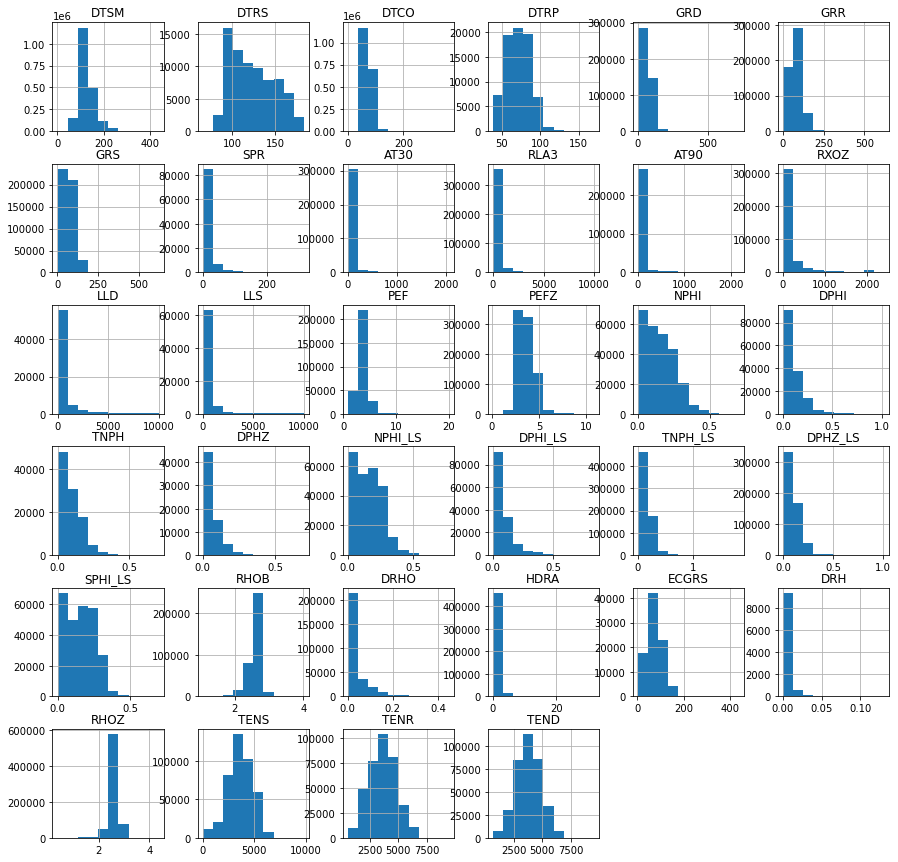

In [14]:
# Examine all data distribution
fig, ax = plt.subplots(figsize=(15,15))
df_alldata.hist(ax=ax)
plt.show()

In [15]:
# Merge data based on log dictionary groups, if each key has multiple values, use average
df_alldata_grouped = pd.DataFrame(columns=log_dict.keys())
for key in log_dict.keys():
    curves = log_dict[key]
    df_temp =df_alldata[curves]
    # take the average of each row for each key
    df_alldata_grouped[key]=np.array(df_temp.mean(axis=1, skipna=True))

df_alldata_grouped.dropna(axis=0, how='any', inplace=True)
df_alldata_grouped.shape

(168210, 8)

<ipython-input-16-766c47ba6a2e>:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  df_alldata_grouped.hist(ax=ax)


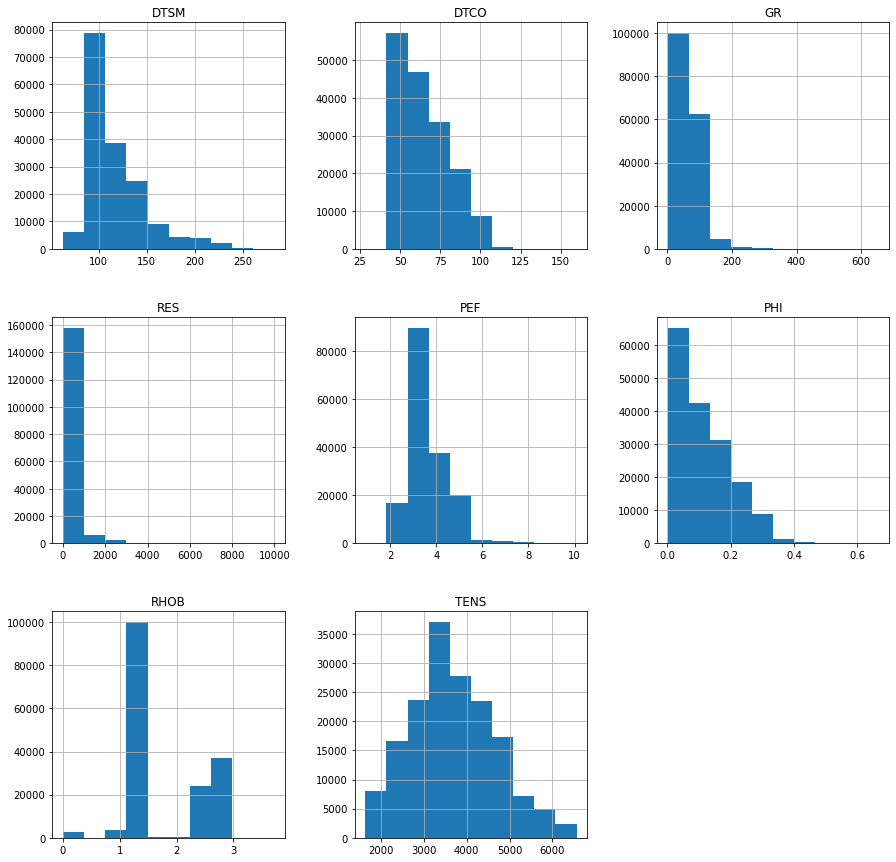

In [16]:
# Examine all_data_group distribution
fig, ax = plt.subplots(figsize=(15,15))
df_alldata_grouped.hist(ax=ax)
plt.show()

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectPercentile
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, silhouette_score
import xgboost
import scipy

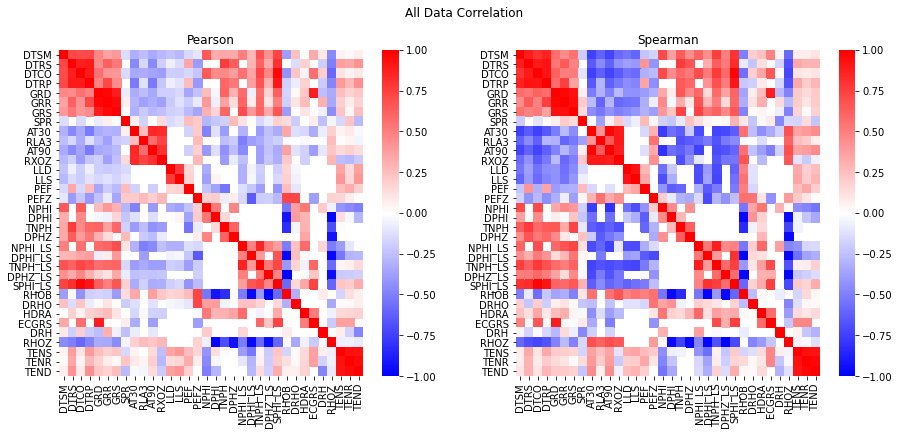

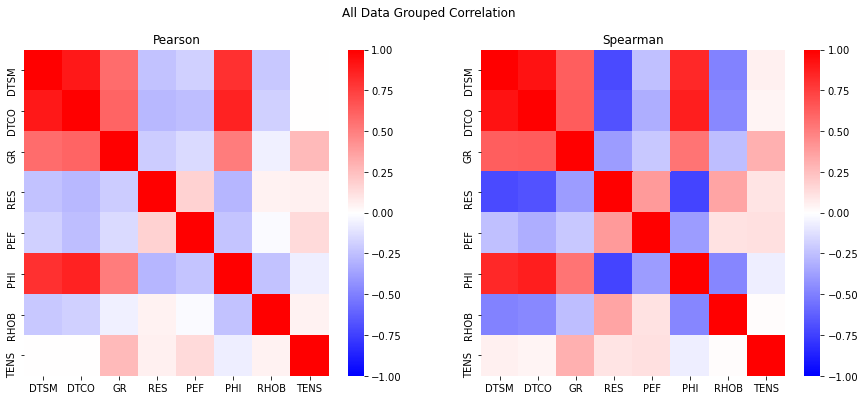

,DTSM,DTCO,GR,RES,PEF,PHI,RHOB,TENS
DTSM,1.000000,0.929436,0.629555,-0.705185,-0.245548,0.842517,-0.491457,0.056811
DTCO,0.929436,1.000000,0.634559,-0.677272,-0.317691,0.882595,-0.468483,0.045771
GR,0.629555,0.634559,1.000000,-0.390136,-0.213407,0.539602,-0.255208,0.306046
RES,-0.705185,-0.677272,-0.390136,1.000000,0.395063,-0.732543,0.353325,0.104252
PEF,-0.245548,-0.317691,-0.213407,0.395063,1.000000,-0.388813,0.116272,0.121106


In [18]:
# Inspect correlations (will be slow)

# 1. df_alldata
df_corr = df_alldata.copy()
corr_pearson = df_corr.corr(method='pearson') 
corr_spearman = df_corr.corr(method='spearman') 

fig, ax = plt.subplots(1, 2, figsize=(15,6))
sns.heatmap(corr_pearson, xticklabels=corr_pearson.columns, yticklabels=corr_pearson.columns,
            center=0, vmin=-1, vmax=1,cmap='bwr', ax=ax[0])
sns.heatmap(corr_spearman, xticklabels=corr_spearman.columns, yticklabels=corr_spearman.columns,
            center=0, vmin=-1, vmax=1,cmap='bwr', ax=ax[1])

ax[0].set(title='Pearson')
ax[1].set(title='Spearman')
fig.suptitle('All Data Correlation')
plt.show()
corr_spearman.head()

# 2. df_alldata_grouped
df_corr = df_alldata_grouped.copy()
corr_pearson = df_corr.corr(method='pearson') 
corr_spearman = df_corr.corr(method='spearman') 

fig, ax = plt.subplots(1, 2, figsize=(15,6))
sns.heatmap(corr_pearson, xticklabels=corr_pearson.columns, yticklabels=corr_pearson.columns,
            center=0, vmin=-1, vmax=1,cmap='bwr', ax=ax[0])
sns.heatmap(corr_spearman, xticklabels=corr_spearman.columns, yticklabels=corr_spearman.columns,
            center=0, vmin=-1, vmax=1,cmap='bwr', ax=ax[1])

ax[0].set(title='Pearson')
ax[1].set(title='Spearman')
fig.suptitle('All Data Grouped Correlation')
plt.show()
corr_spearman.head()

In [19]:
# Check rank correlation
corr_spearman['DTSM'].abs().sort_values(ascending=False)

DTSM    1.000000
DTCO    0.929436
PHI     0.842517
RES     0.705185
GR      0.629555
RHOB    0.491457
PEF     0.245548
TENS    0.056811
Name: DTSM, dtype: float64

In [20]:
# # Select the variables that have highest correlation with DTSM
top_features = corr_spearman['DTSM'].abs().sort_values(ascending=False)[:10].index.to_list().copy()
print(top_features)

['DTSM', 'DTCO', 'PHI', 'RES', 'GR', 'RHOB', 'PEF', 'TENS']


In [21]:
# Prepare predictor and response variables

features = top_features.copy()
df_alldata_lean = df_alldata_grouped.copy()
df_alldata_lean = df_alldata_lean[features]
df_alldata_lean.dropna(axis=0, how='any', inplace=True)

features.remove('DTSM')

df_X = df_alldata_lean[features]
df_y = df_alldata_lean[['DTSM']]

if log_transform:
    df_X = df_X.transform(np.log)
    # df_X_log = df_X.transform(np.log) # log transform variables
    # df_X = df_X_log.copy()
  
print('X shape: ', df_X.shape)
print('y shape: ', df_y.shape)

X shape:  (168210, 7)
y shape:  (168210, 1)


In [22]:
# Remove outliers upfront
iforest = IsolationForest(n_estimators=200, contamination='auto', random_state=0)
iforest = iforest.fit(df_X) 

iforest_pred = iforest.predict(df_X)
mask_in = iforest_pred == 1

df_X = df_X[mask_in].copy() 
df_y = df_y[mask_in].copy()
print('X shape: ', df_X.shape)
print('y shape: ', df_y.shape)

X shape:  (147033, 7)
y shape:  (147033, 1)


In [23]:
df_X

,DTCO,PHI,RES,GR,RHOB,PEF,TENS
63690,4.043718,-2.295609,2.834489,4.000493,0.313496,1.262996,7.652528
63691,4.053608,-2.641794,2.351423,4.067512,0.297583,1.221125,7.656109
63692,4.076900,-2.571773,2.481768,4.072709,0.292931,1.219620,7.657241
63693,4.101362,-2.604141,2.772964,4.045030,0.298251,1.219531,7.658372
63694,4.117110,-2.589823,2.987640,4.059336,0.303285,1.219531,7.659129
...,...,...,...,...,...,...,...
1931395,3.912461,-2.524479,2.972576,3.147207,0.285705,1.151173,7.496532
1940395,4.292884,-1.951928,-2.645075,4.486726,0.947983,1.265425,8.046866
1940396,4.277963,-1.989601,-1.776083,4.465176,0.261479,1.179209,8.044056
1940397,4.262815,-2.041760,-1.318636,4.437342,0.266165,1.019677,8.041338


# Regression Models

In [24]:
# Split data
X = np.array(df_X)
y = np.array(df_y).ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
print(X_train.shape)
print(X_test.shape)

# Scale data
scaler = RobustScaler(quantile_range=(2.5, 97.5))
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# # Remove outliers
# iforest = IsolationForest(n_estimators=200, contamination='auto', random_state=0)
# iforest = iforest.fit(X_train_s) 

# iforest_pred = iforest.predict(X_train_s)
# mask_in = iforest_pred == 1
# X_train_s_in = X_train_s[mask_in] 
# y_train_in = y_train[mask_in]


# X_train_s_in_d = select.transform(X_train_s)
# X_test_s_d = select.transform(X_test_s)



(73516, 7)
(73517, 7)


In [25]:
# CV = KFold(n_splits=3, shuffle = True, random_state=0)
# metrics = ['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error', 
#                 'neg_root_mean_squared_error'] 
# metrics = 'r2'

X_to_fit = X_train_s
X_to_test = X_test_s            

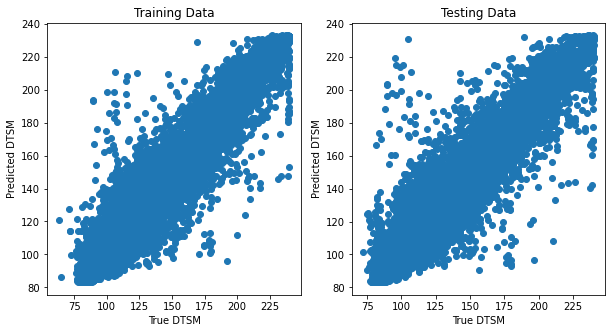

Training R2 score:  0.9595867315594202
Testing R2 score:  0.95417855858133
['DTCO', 'PHI', 'RES', 'GR', 'RHOB', 'PEF', 'TENS'] [0.64895122 0.24645871 0.06252327 0.02043327 0.0028454  0.00577797
 0.01301016]


In [26]:
# Try random forest
rf = RandomForestRegressor(max_depth=9, min_samples_leaf=0.0001, max_features=0.8, n_estimators=100, random_state=0) 
                            # These parameters are obtained after paramter optimization
rf.fit(X_to_fit, y_train)
y_train_pred = rf.predict(X_to_fit)
y_test_pred = rf.predict(X_to_test)
importance = rf.feature_importances_
sort_idx = np.argsort(importance)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(y_train, y_train_pred)
ax[0].set(xlabel='True DTSM', ylabel='Predicted DTSM', title='Training Data')
ax[1].scatter(y_test, y_test_pred)
ax[1].set(xlabel='True DTSM', ylabel='Predicted DTSM', title='Testing Data')
plt.show()
print('Training R2 score: ', r2_score(y_train, y_train_pred))
print('Testing R2 score: ', r2_score(y_test, y_test_pred))
print(features,importance)

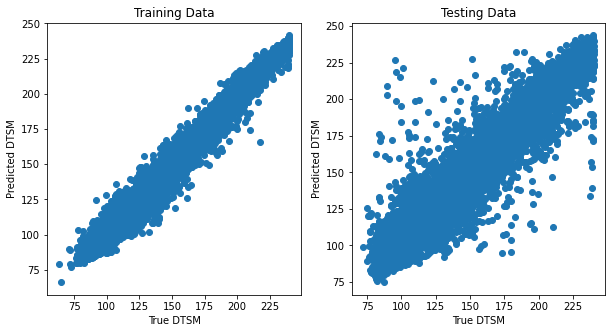

Training R2 score:  0.9894119550185019
Testing R2 score:  0.9639682260279204


In [27]:
# Try XGBoost

xgb = xgboost.XGBRegressor(objective='reg:squarederror', max_depth=9, booster='gbtree')
xgb.fit(X_to_fit, y_train)
y_train_pred = xgb.predict(X_to_fit)
y_test_pred = xgb.predict(X_to_test)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(y_train, y_train_pred)
ax[0].set(xlabel='True DTSM', ylabel='Predicted DTSM', title='Training Data')
ax[1].scatter(y_test, y_test_pred)
ax[1].set(xlabel='True DTSM', ylabel='Predicted DTSM', title='Testing Data')
plt.show()
print('Training R2 score: ', r2_score(y_train, y_train_pred))
print('Testing R2 score: ', r2_score(y_test, y_test_pred))


In [28]:
# # Random forest grid search
# method = 'rf'
# rf = RandomForestRegressor()
# params = {
#         'max_depth': np.arange(2, 8, 1), \
#         'max_features': [0.2, 0.5, 0.8], \
#         'min_samples_leaf': np.arange(5, 20, 5), \
#         'n_estimators': [100, 200, 300], \
#         'random_state': [0]}
# grid = GridSearchCV(estimator=rf, param_grid=params, cv=CV, verbose=1, 
#                     scoring=metrics, refit='neg_mean_absolute_error')   
# grid.fit(X_to_fit, y_train)


In [29]:
# grid.best_params_
# y_test_pred = grid.predict(X_to_test)


# fig, ax = plt.subplots(figsize=(7,7))
# ax.scatter(y_test, y_test_pred)
# ax.set(xlabel='True DTSM', ylabel='Predicted DTSM')
# print(r2_score(y_test, y_test_pred))


# Train model based on available logs in test data



In [30]:
for idx, las in enumerate(all_las_test):
    las.well.UWI = testfilenames_s[idx]
    df_las = las.df()
    print(str(idx), las.well.UWI.value, 'length: ', len(df_las.index))

0 00d02be79f49_TGS length:  13255
1 0a7822c59487_TGS length:  3671
2 113412eec2a6_TGS length:  1465
3 1684cc35f399_TGS length:  12846
4 20372701d5e2_TGS length:  3957
5 2f96a5f92418_TGS length:  5031
6 302460e3021a_TGS length:  1291
7 3369b6f8fb6f_TGS length:  1893
8 34a80ab7a5fa_TGS length:  5135
9 63250f7d463b_TGS length:  1737
10 638f2cc65681_TGS length:  2019
11 7595ba9fb314_TGS length:  1401
12 84c5fb9cc880_TGS length:  3497
13 8e37531ba266_TGS length:  2147
14 94c1f5cae85c_TGS length:  1307
15 ae16a9f64878_TGS length:  21678
16 ed48bda2217f_TGS length:  16926
17 eed1e9537976_TGS length:  13883
18 fca03aa6acde_TGS length:  10745
19 ff7845ea074d_TGS length:  24122


In [31]:
# Run for each blind test well
las_blind = all_las_test[0] 
testwell=las_blind.well.UWI.value
df_las_blind = las_blind.df()

print(testwell)
df_las_blind

00d02be79f49_TGS


,GRR,ILD,ILM,SFLU,SPR,CALR,DTCO,NPHI,DPHI,PE,DRHO,CALD,RHOB
DEPT,,,,,,,,,,,,,
5994.0,82.4304,9.1583,8.6697,8.6378,-24.9283,9.4701,71.2017,NaN,NaN,NaN,NaN,NaN,NaN
5994.5,80.1221,9.1626,8.6134,9.4136,-26.6600,9.4440,70.2243,NaN,NaN,NaN,NaN,NaN,NaN
5995.0,77.1246,9.1152,8.4855,10.0892,-27.2562,9.4560,67.5032,NaN,NaN,NaN,NaN,NaN,NaN
5995.5,76.2724,8.9201,8.3596,10.0951,-28.3344,9.4822,60.7898,NaN,NaN,NaN,NaN,NaN,NaN
5996.0,77.7058,8.1558,8.1499,9.8005,-30.2277,9.5882,56.5389,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12619.0,49.2102,19.4078,20.4200,26.9811,-4.6927,NaN,59.9214,0.0147,0.0018,NaN,0.0079,8.0495,2.7033
12619.5,43.3629,20.3790,21.6651,32.2151,-3.6559,NaN,58.4130,0.0146,-0.0011,NaN,0.0130,8.0495,2.7145
12620.0,38.6789,21.3987,23.6279,42.7477,-3.2519,NaN,56.8803,0.0144,-0.0159,NaN,0.0160,8.0244,2.7338


In [32]:
# Process blind test well data
# group logs in test well
df_las_blind_grouped = pd.DataFrame(columns=features)

cols = df_las_blind.columns.to_list()

for key in features:
    curves = log_dict[key]
    cols_seleted = []
    for c in cols:
        if c in curves:
            cols_seleted.append(c)

    df_temp =df_las_blind[cols_seleted]
    # take the average of each row for each key, omitting nan
    df_las_blind_grouped[key]=np.array(df_temp.mean(axis=1, skipna=True))

df_las_blind_grouped['DEPT'] = df_las_blind.index      # append depth and set as index
df_las_blind_grouped.set_index('DEPT', inplace=True)

df_las_blind_grouped[df_las_blind_grouped>cutoff_hi] = np.nan
df_las_blind_grouped[df_las_blind_grouped<cutoff_lo] = np.nan

# Drop columns that are mostly nans
cols_drop = []
for col in df_las_blind_grouped.columns:
    if df_las_blind_grouped[col].isna().sum()/df_las_blind_grouped.shape[0] > 0.8:
        cols_drop.append(col)

df_las_blind_grouped.drop(cols_drop, axis=1, inplace=True)

df_las_blind_grouped.dropna(axis=1, how='all', inplace=True) # Drop nan columns only, DO NOT DROP NAN ROWS
print('Raw test well log shape: ', df_las_blind.shape)
print('Grouped test well log shape: ', df_las_blind_grouped.shape)
print('Grouped test well logs: ', df_las_blind_grouped.columns)

# Find common logs in training data and blind test wells
common_features = []

for i in df_las_blind_grouped.columns.to_list():
    if i in features:
        common_features.append(i)
    # elif i in log_priority_list:
    #     common_features.append(i) 

if not common_features: # if common_features is empty, use DTCO
    common_features=['DTCO']
print('Common features: ', common_features)

Raw test well log shape:  (13255, 13)
Grouped test well log shape:  (13255, 4)
Grouped test well logs:  Index(['DTCO', 'PHI', 'GR', 'RHOB'], dtype='object')
Common features:  ['DTCO', 'PHI', 'GR', 'RHOB']


00d02be79f49_TGS
(73516, 4)
(73517, 4)


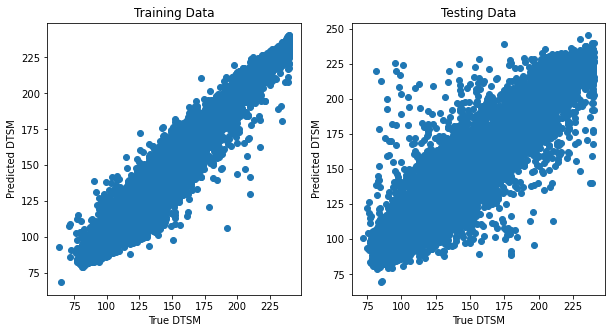

Training score:  0.9739270581525847
Testing score:  0.93901589614671


In [33]:

############################################################
## Training model using common features found in test well
############################################################

print(testwell)

# Split data
X = np.array(df_X[common_features]) 
y = np.array(df_y).ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
print(X_train.shape)
print(X_test.shape)

# Scale data
scaler = RobustScaler(quantile_range=(2.5, 97.5))
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# Remove outliers
iforest = IsolationForest(n_estimators=200, contamination='auto', random_state=0)
iforest = iforest.fit(X_train_s) 

iforest_pred = iforest.predict(X_train_s)
mask_in = iforest_pred == 1
X_train_s_in = X_train_s[mask_in] 
y_train_in = y_train[mask_in]

CV = KFold(n_splits=3, shuffle = True, random_state=0)
metrics = ['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error', 
                'neg_root_mean_squared_error'] 
metrics = 'r2'
X_to_fit = X_train_s
y_to_fit = y_train
X_to_test = X_test_s  

# # Random forest
# rf = RandomForestRegressor(max_depth=8, min_samples_leaf=0.0001, max_features=0.6, random_state=0) # This is taken from randomized search cv
# rf.fit(X_to_fit, y_train)
# y_train_pred = rf.predict(X_to_fit)
# y_test_pred = rf.predict(X_to_test)
# importance = rf.feature_importances_.flatten()
# sort_idx = np.argsort(importance)[::-1]

# fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# ax[0].scatter(y_train, y_train_pred)
# ax[0].set(xlabel='True DTSM', ylabel='Predicted DTSM', title='Training Data')
# ax[1].scatter(y_test, y_test_pred)
# ax[1].set(xlabel='True DTSM', ylabel='Predicted DTSM', title='Testing Data')
# plt.show()
# print('Training score: ', r2_score(y_train, y_train_pred))
# print('Testing score: ', r2_score(y_test, y_test_pred))
# print(features,importance)

# XGBoost
xgb = xgboost.XGBRegressor(objective='reg:squarederror', max_depth=9)
xgb.fit(X_to_fit, y_to_fit)
y_train_pred = xgb.predict(X_to_fit)
y_test_pred = xgb.predict(X_to_test)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(y_to_fit, y_train_pred)
ax[0].set(xlabel='True DTSM', ylabel='Predicted DTSM', title='Training Data')
ax[1].scatter(y_test, y_test_pred)
ax[1].set(xlabel='True DTSM', ylabel='Predicted DTSM', title='Testing Data')
plt.show()
print('Training score: ', r2_score(y_to_fit, y_train_pred))
print('Testing score: ', r2_score(y_test, y_test_pred))


In [34]:

##########################
## Blind test prediction
##########################
model = xgb # select trained model, xgb is preferred

# Preprocess 
df_blindtest = df_las_blind_grouped[common_features].copy()


df_blindtest[df_blindtest>cutoff_hi]=np.nan
df_blindtest[df_blindtest<cutoff_lo]=np.nan
df_blindtest.dropna(axis=0, how='any', inplace=True) 
        # Drop nan rows because the model can only predict where all common features are present

if log_transform:
      df_blindtest = df_blindtest.transform(np.log)
      # df_blindtest = df_blindtest.transform(np.log)

df_blindtest_s = scaler.transform(df_blindtest)

y_blindtest = model.predict(df_blindtest_s) # make prediction for DTSM using the trained model

df_blindtest['DTSM_pred'] = y_blindtest
df_to_add = df_blindtest[['DTSM_pred']]
df_las_new_grouped = pd.merge(df_las_blind_grouped, df_to_add, how='outer', left_index=True, right_index=True)
df_las_new = pd.merge(df_las_blind, df_to_add, how='outer', left_index=True, right_index=True)
print('Number of missing rows after first pass prediction: ', (len(df_las_blind)-len(y_blindtest)))
df_las_new

Number of missing rows after first pass prediction:  2129


,GRR,ILD,ILM,SFLU,SPR,CALR,DTCO,NPHI,DPHI,PE,DRHO,CALD,RHOB,DTSM_pred
DEPT,,,,,,,,,,,,,,
5994.0,82.4304,9.1583,8.6697,8.6378,-24.9283,9.4701,71.2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5994.5,80.1221,9.1626,8.6134,9.4136,-26.6600,9.4440,70.2243,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5995.0,77.1246,9.1152,8.4855,10.0892,-27.2562,9.4560,67.5032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5995.5,76.2724,8.9201,8.3596,10.0951,-28.3344,9.4822,60.7898,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5996.0,77.7058,8.1558,8.1499,9.8005,-30.2277,9.5882,56.5389,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12619.0,49.2102,19.4078,20.4200,26.9811,-4.6927,NaN,59.9214,0.0147,0.0018,NaN,0.0079,8.0495,2.7033,103.232040
12619.5,43.3629,20.3790,21.6651,32.2151,-3.6559,NaN,58.4130,0.0146,-0.0011,NaN,0.0130,8.0495,2.7145,102.873642
12620.0,38.6789,21.3987,23.6279,42.7477,-3.2519,NaN,56.8803,0.0144,-0.0159,NaN,0.0160,8.0244,2.7338,NaN


In [35]:
#######################################################################
## Secondary prediction if there are depths without predicted values
#######################################################################
df_train = df_las_new[~df_las_new['DTSM_pred'].isna()].copy()
df_test = df_las_new[df_las_new['DTSM_pred'].isna()].copy()
print('Predicted after first pass: ', df_train.shape)
print('Not predicted after first pass: ', df_test.shape)

Predicted after first pass:  (11126, 14)
Not predicted after first pass:  (2129, 14)


In [36]:
if df_las_new['DTSM_pred'].isna().any():

    df_train = df_las_new_grouped[~df_las_new_grouped['DTSM_pred'].isna()].copy() # Used successfully predicted rows within this well as training for secondary prediction
    df_test = df_las_new_grouped[df_las_new_grouped['DTSM_pred'].isna()].copy()

    missing_depths = df_test.index

    ## Initiate a model using the features availabe in the first missing row, this is to make the for loop work
    df_train_X = df_train.copy()        
    df_train_X.drop('DTSM_pred', axis=1, inplace=True)
    df_train_y = df_train[['DTSM_pred']].copy()

    df_testrow = df_test.loc[[missing_depths[0]]].copy()
    df_testrow_y = df_testrow['DTSM_pred'].copy()
    df_testrow_X = df_testrow.copy()
    df_testrow_X.dropna(axis=1, how='all', inplace=True)

    cols_keep = df_testrow_X.columns
    df_train_X = df_train_X[cols_keep].copy()
        
    # Split data
    X = np.array(df_train_X)
    y = np.array(df_train_y).ravel()

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0) # Use a smaller test data set here because we're now within the well with fewer data points

    # Scaling
    scaler = RobustScaler(quantile_range=(2.5, 97.5))
    X_train_s = scaler.fit_transform(X_train)
    X_val_s = scaler.transform(X_val)

    model1 = xgboost.XGBRegressor(objective='reg:squarederror')
    model2 = RandomForestRegressor(max_depth=10, min_samples_leaf=0.0001, max_features=1, random_state=0)
    model1.fit(X_train_s, y_train)
    model2.fit(X_train_s, y_train)
    y_val_pred1 = model1.predict(X_val_s)
    y_val_pred2 = model2.predict(X_val_s)
    r2_1 = r2_score(y_val, y_val_pred1)
    r2_2 = r2_score(y_val, y_val_pred2)

    if r2_1 > r2_2:
        method = 'XGBoost'
        model = model1
        r2_secondary = r2_1
    else:
        method = 'Random Forest'
        model = model2
        r2_secondary = r2_2
    print('Secondary prediction ', method, ' R2: ', r2_secondary)

    # Predict the rest of the missing rows
    for missing_depth in df_test.index:
        print('Predictin missing depth: ', missing_depth)

        df_train_X = df_train.copy()
        df_train_X.drop('DTSM_pred', axis=1, inplace=True)
        df_train_y = df_train[['DTSM_pred']].copy()

        df_testrow = df_test.loc[[missing_depth]].copy() # Extract the missing row

        df_testrow_y = df_testrow['DTSM_pred'].copy()
        df_testrow_X = df_testrow.copy()
        df_testrow_X.dropna(axis=1, how='all', inplace=True) # ???????? We can only use columns available in the test row

        cols_keep_new = df_testrow_X.columns

        if cols_keep_new.empty != True: # Proceed if there are available columns, there can be no columns availabe when the raw data have curves not in our dictionary
                 
            if cols_keep_new.to_list() == cols_keep.to_list(): # Use the previous model if the missing row has the same features as previous missing row
                y_val_pred = model.predict(X_val_s)
                print('Secondary prediction ', method, ' R2: ', r2_secondary)

                X_test_s = scaler.transform(df_testrow_X)
                y_test = model.predict(X_test_s)

                df_las_new_grouped.loc[missing_depth, 'DTSM_pred'] = y_test
                df_las_new.loc[missing_depth, 'DTSM_pred'] = y_test
                # print(df_las_new_grouped.loc[[missing_depth]])   

            else: # If available features in the missing row are different than previous row, then train a model separately using available features  
                df_train_X = df_train_X[cols_keep_new].copy() 

                # Split data
                X = np.array(df_train_X)
                y = np.array(df_train_y).ravel()

                X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

                # Scaling
                scaler = RobustScaler(quantile_range=(2.5, 97.5))
                X_train_s = scaler.fit_transform(X_train)
                X_val_s = scaler.transform(X_val)

                model1 = xgboost.XGBRegressor(objective='reg:squarederror')
                model2 = RandomForestRegressor(max_depth=10, min_samples_leaf=0.0001, max_features=1, random_state=0)
                model1.fit(X_train_s, y_train)
                model2.fit(X_train_s, y_train)
                y_val_pred1 = model1.predict(X_val_s)
                y_val_pred2 = model2.predict(X_val_s)
                r2_1 = r2_score(y_val, y_val_pred1)
                r2_2 = r2_score(y_val, y_val_pred2)

                if r2_1 > r2_2:
                    method = 'XGBoost'
                    model = model1
                    r2_secondary = r2_1
                else:
                    method = 'Random Forest'
                    model = model2
                    r2_secondary = r2_2
                print('Secondary prediction ', method, ' R2: ', r2_secondary)

                X_test_s = scaler.transform(df_testrow_X)
                y_test = model.predict(X_test_s)

                df_las_new_grouped.loc[missing_depth, 'DTSM_pred'] = y_test
                df_las_new.loc[missing_depth, 'DTSM_pred'] = y_test
                # print(df_las_new_grouped.loc[[missing_depth]])  
            
            cols_keep = cols_keep_new.copy() # update cols_keep

        else: # If missing row has no features available, train model using available curves in raw data. 

            df_train = df_las_new[~df_las_new['DTSM_pred'].isna()].copy() # df_las_new has columns in raw data
            df_test = df_las_new[df_las_new['DTSM_pred'].isna()].copy()
            df_testrow = df_test.loc[[missing_depth]].copy()

            df_train_X = df_train.copy()
            df_train_X.drop('DTSM_pred', axis=1, inplace=True)
            df_train_y = df_train[['DTSM_pred']].copy()

            df_testrow_X = df_testrow.copy()
            df_testrow_X.dropna(axis=1, how='all', inplace=True)         
            df_testrow_y = df_testrow['DTSM_pred'].copy()

            cols_keep = df_testrow_X.columns
            df_train_X = df_train_X[cols_keep].copy()
              
            # Split data
            X = np.array(df_train_X)
            y = np.array(df_train_y).ravel()

            X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

            # Scaling
            scaler = RobustScaler(quantile_range=(2.5, 97.5))
            X_train_s = scaler.fit_transform(X_train)
            X_val_s = scaler.transform(X_val)

            model1 = xgboost.XGBRegressor(objective='reg:squarederror')
            model2 = RandomForestRegressor(max_depth=10, min_samples_leaf=0.0001, max_features=1, random_state=0)
            model1.fit(X_train_s, y_train)
            model2.fit(X_train_s, y_train)
            y_val_pred1 = model1.predict(X_val_s)
            y_val_pred2 = model2.predict(X_val_s)
            r2_1 = r2_score(y_val, y_val_pred1)
            r2_2 = r2_score(y_val, y_val_pred2)

            if r2_1 > r2_2:
                method = 'XGBoost'
                model = model1
                r2_secondary = r2_1
            else:
                method = 'Random Forest'
                model = model2
                r2_secondary = r2_2
            print('Secondary prediction ', method, ' R2: ', r2_secondary)

            X_test_s = scaler.transform(df_testrow_X)
            y_test = model.predict(X_test_s)

            df_las_new_grouped.loc[missing_depth, 'DTSM_pred'] = y_test
            df_las_new.loc[missing_depth, 'DTSM_pred'] = y_test
            
            # print(df_las_new.loc[[missing_depth]])


Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  5994.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  5994.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  5995.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  5995.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  5996.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  5996.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  5997.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  5997.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  5998.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  5998.5
Secondary prediction  Random Forest  R2:  0.8881439793401399

Predictin missing depth:  6039.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6039.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6040.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6040.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6041.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6041.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6042.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6042.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6043.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6043.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6044.0
Secondary prediction  Rando

Predictin missing depth:  6083.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6083.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6084.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6084.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6085.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6085.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6086.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6086.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6087.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6087.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6088.0
Secondary prediction  Rando

Predictin missing depth:  6127.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6128.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6128.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6129.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6129.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6130.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6130.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6131.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6131.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6132.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6132.5
Secondary prediction  Rando

Predictin missing depth:  6172.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6173.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6173.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6174.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6174.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6175.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6175.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6176.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6176.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6177.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6177.5
Secondary prediction  Rando

Predictin missing depth:  6218.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6218.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6219.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6219.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6220.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6220.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6221.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6221.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6222.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6222.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6223.0
Secondary prediction  Rando

Predictin missing depth:  6262.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6262.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6263.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6263.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6264.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6264.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6265.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6265.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6266.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6266.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6267.0
Secondary prediction  Rando

Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6307.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6307.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6308.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6308.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6309.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6309.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6310.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6310.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6311.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6311.5
Secondary prediction  Random Forest  R2:  0.8881439793401399

Predictin missing depth:  6352.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6352.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6353.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6353.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6354.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6354.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6355.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6355.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6356.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6356.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6357.0
Secondary prediction  Rando

Predictin missing depth:  6397.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6397.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6398.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6398.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6399.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6399.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6400.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6400.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6401.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6401.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6402.0
Secondary prediction  Rando

Predictin missing depth:  6442.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6442.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6443.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6443.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6444.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6444.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6445.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6445.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6446.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6446.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6447.0
Secondary prediction  Rando

Predictin missing depth:  6487.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6487.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6488.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6488.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6489.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6489.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6490.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6490.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6491.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6491.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6492.0
Secondary prediction  Rando

Predictin missing depth:  6532.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6532.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6533.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6533.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6534.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6534.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6535.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6535.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6536.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6536.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6537.0
Secondary prediction  Rando

Predictin missing depth:  6577.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6577.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6578.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6578.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6579.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6579.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6580.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6580.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6581.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6581.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6582.0
Secondary prediction  Rando

Predictin missing depth:  6623.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6623.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6624.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6624.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6625.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6625.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6626.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6626.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6627.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6627.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6628.0
Secondary prediction  Rando

Predictin missing depth:  6667.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6667.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6668.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6668.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6669.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6669.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6670.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6670.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6671.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6671.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6672.0
Secondary prediction  Rando

Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6711.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6712.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6712.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6713.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6713.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6714.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6714.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6715.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6715.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6716.0
Secondary prediction  Random Forest  R2:  0.8881439793401399

Predictin missing depth:  6756.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6757.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6757.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6758.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6758.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6759.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6759.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6760.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6760.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6761.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6761.5
Secondary prediction  Rando

Predictin missing depth:  6802.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6802.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6803.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6803.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6804.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6804.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6805.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6805.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6806.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6806.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6807.0
Secondary prediction  Rando

Predictin missing depth:  6847.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6847.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6848.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6848.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6849.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6849.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6850.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6850.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6851.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6851.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6852.0
Secondary prediction  Rando

Predictin missing depth:  6891.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6892.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6892.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6893.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6893.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6894.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6894.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6895.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6895.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6896.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6896.5
Secondary prediction  Rando

Predictin missing depth:  6936.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6937.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6937.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6938.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6938.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6939.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6939.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6940.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6940.5
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6941.0
Secondary prediction  Random Forest  R2:  0.8881439793401399
Predictin missing depth:  6941.5
Secondary prediction  Rando

Secondary prediction  XGBoost  R2:  0.9161775900085347
Predictin missing depth:  9168.0
Secondary prediction  XGBoost  R2:  0.9161775900085347
Predictin missing depth:  9168.5
Secondary prediction  XGBoost  R2:  0.9161775900085347
Predictin missing depth:  9169.0
Secondary prediction  XGBoost  R2:  0.9161775900085347
Predictin missing depth:  9169.5
Secondary prediction  XGBoost  R2:  0.9161775900085347
Predictin missing depth:  9170.0
Secondary prediction  XGBoost  R2:  0.9161775900085347
Predictin missing depth:  9170.5
Secondary prediction  XGBoost  R2:  0.9161775900085347
Predictin missing depth:  9171.0
Secondary prediction  XGBoost  R2:  0.9161775900085347
Predictin missing depth:  9171.5
Secondary prediction  XGBoost  R2:  0.9161775900085347
Predictin missing depth:  9172.0
Secondary prediction  XGBoost  R2:  0.9161775900085347
Predictin missing depth:  9172.5
Secondary prediction  XGBoost  R2:  0.9161775900085347
Predictin missing depth:  9173.0
Secondary prediction  XGBoost  R

Predictin missing depth:  11435.5
Secondary prediction  XGBoost  R2:  0.9161775900085347
Predictin missing depth:  11436.0
Secondary prediction  XGBoost  R2:  0.9161775900085347
Predictin missing depth:  11438.5
Secondary prediction  XGBoost  R2:  0.9161775900085347
Predictin missing depth:  11439.0
Secondary prediction  XGBoost  R2:  0.9161775900085347
Predictin missing depth:  11439.5
Secondary prediction  XGBoost  R2:  0.9161775900085347
Predictin missing depth:  11440.0
Secondary prediction  XGBoost  R2:  0.9161775900085347
Predictin missing depth:  11440.5
Secondary prediction  XGBoost  R2:  0.9161775900085347
Predictin missing depth:  11441.0
Secondary prediction  XGBoost  R2:  0.9161775900085347
Predictin missing depth:  11441.5
Secondary prediction  XGBoost  R2:  0.9161775900085347
Predictin missing depth:  11442.0
Secondary prediction  XGBoost  R2:  0.9161775900085347
Predictin missing depth:  11451.5
Secondary prediction  XGBoost  R2:  0.9161775900085347
Predictin missing dep

In [37]:
cols_keep_new

Index(['DTCO', 'GR', 'RHOB'], dtype='object')

In [38]:
# Write output
df_las_new.sort_index(inplace=True)
df_las_new.rename(columns={'DTSM_pred': 'DTSM'}, inplace=True)
df_las_new.index.name = 'Depth'
print(df_las_blind.shape)
print(df_las_new['DTSM'].shape)
print('Number of missing predictions: ', str(df_las_new['DTSM'].isna().sum()))
df_las_new.to_excel(os.path.join(projfolder,'Output','TestAll', testwell+'.xlsx'))


(13255, 13)
(13255,)
Number of missing predictions:  0


In [39]:
df_las_new

,GRR,ILD,ILM,SFLU,SPR,CALR,DTCO,NPHI,DPHI,PE,DRHO,CALD,RHOB,DTSM
Depth,,,,,,,,,,,,,,
5994.0,82.4304,9.1583,8.6697,8.6378,-24.9283,9.4701,71.2017,NaN,NaN,NaN,NaN,NaN,NaN,123.554153
5994.5,80.1221,9.1626,8.6134,9.4136,-26.6600,9.4440,70.2243,NaN,NaN,NaN,NaN,NaN,NaN,125.488731
5995.0,77.1246,9.1152,8.4855,10.0892,-27.2562,9.4560,67.5032,NaN,NaN,NaN,NaN,NaN,NaN,117.906898
5995.5,76.2724,8.9201,8.3596,10.0951,-28.3344,9.4822,60.7898,NaN,NaN,NaN,NaN,NaN,NaN,107.558067
5996.0,77.7058,8.1558,8.1499,9.8005,-30.2277,9.5882,56.5389,NaN,NaN,NaN,NaN,NaN,NaN,97.191231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12619.0,49.2102,19.4078,20.4200,26.9811,-4.6927,NaN,59.9214,0.0147,0.0018,NaN,0.0079,8.0495,2.7033,103.232040
12619.5,43.3629,20.3790,21.6651,32.2151,-3.6559,NaN,58.4130,0.0146,-0.0011,NaN,0.0130,8.0495,2.7145,102.873642
12620.0,38.6789,21.3987,23.6279,42.7477,-3.2519,NaN,56.8803,0.0144,-0.0159,NaN,0.0160,8.0244,2.7338,100.491806


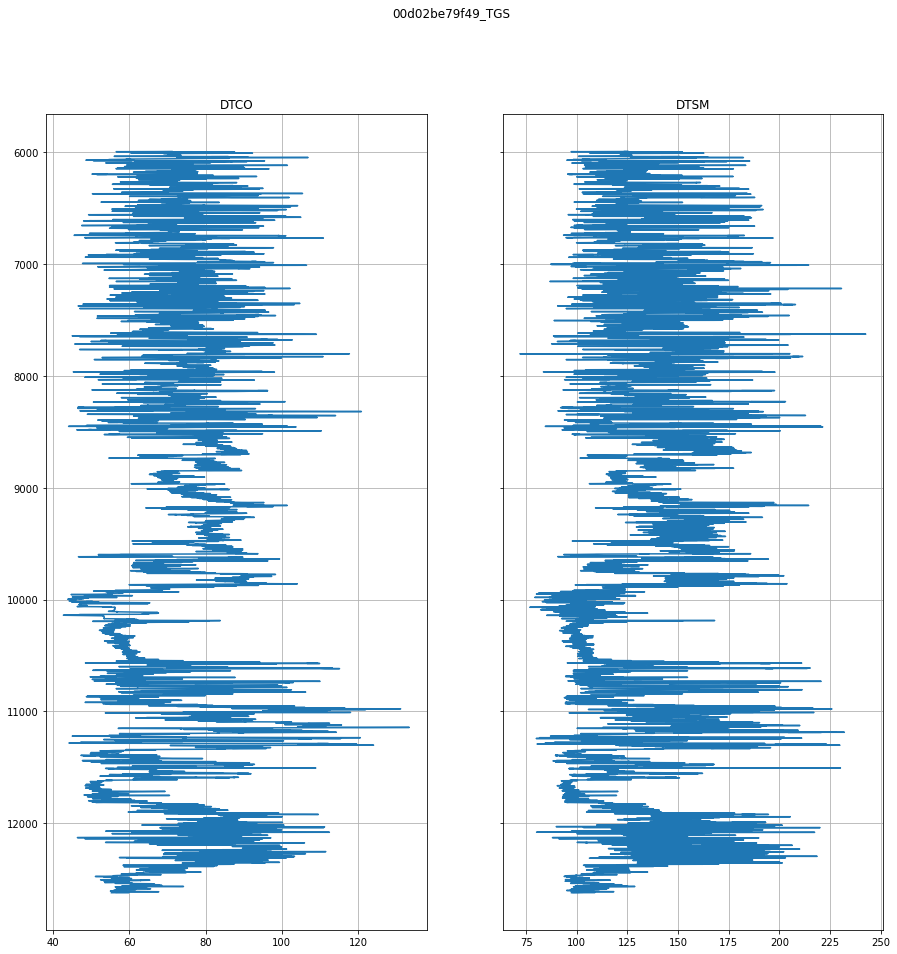

In [40]:
# Plot DTCO and predicted DTSM, they should look correlated
fig, ax = plt.subplots(1,2, figsize=(15,15),sharey=True)
ax[0].plot(df_las_blind['DTCO'], df_las_blind.index)
ax[0].invert_yaxis()
ax[0].set(title='DTCO')
ax[0].grid()
ax[1].plot(df_las_new['DTSM'], df_las_new.index)
# ax[1].invert_yaxis()
ax[1].set(title='DTSM')
ax[1].grid()
plt.suptitle(testwell)
plt.show()



# End